In [281]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import nibabel as nb
import mne

In [117]:
import math
def lcm(a,b):
  return (a * b) // math.gcd(a,b)
lcm(512*3, 200)

38400

In [118]:
def downsampling(signal, orig_srate, target_srate):
    from scipy.interpolate import griddata
    import scipy.signal
    import pyedflib
    # Based on code from Mike X Cohen course (Complete neural signal processing and analysis: Zero to hero)
    if orig_srate < target_srate:
        raise Exception('This function only works to downsample and the given original sample rate is bigger than the target one.')
    elif orig_srate == target_srate:
        return signal
    # Get info from given signal
    npnts = signal.shape[0]
    time  = np.arange(0,npnts)/orig_srate
    
    # Upsample the signal close to a multiple of target_srate
    upsampleFactor = int(np.ceil(orig_srate/target_srate))
    newSrate = upsampleFactor*target_srate
    # print(newSrate)
    # print(npnts)
    # print(newSrate/orig_srate)
    # need to round in case it's not exact
    newNpnts = np.round( npnts * (newSrate/orig_srate) )
    # print(newNpnts)
    
    # new time vector after upsampling
    newTime = np.arange(0,newNpnts) / newSrate
    # print(newTime)
    
    ## continue on to interpolation

    # cut out extra time points: we don't want any data above the original last data
    newTime = newTime[newTime<=time[-1]]
    # print(newTime)
    
    # the new sampling rate actually implemented
    newSrateActual = np.round(1/np.mean(np.diff(newTime)),4)
    # print(newSrateActual)
    
    ## Downsample to target_srate
    downsampleFactor = int(np.floor(newSrateActual/target_srate))
    downsampledSrate = newSrateActual/downsampleFactor
    
    # new time vector after upsampling
    newTv = np.arange(0,newTime[-1],1/downsampledSrate)
    newPnts = len(newTv)
    # print(newPnts)
    
    # interpolate using griddata
    upsampled_signal = griddata(time, signal, newTime, method='cubic')
    ### low-pass filter at new Nyquist frequency!
    fkern = scipy.signal.firwin(int(14*downsampledSrate/2),downsampledSrate/2,fs=newSrateActual,pass_zero=True)
    fsignal = scipy.signal.filtfilt(fkern,1,upsampled_signal)

    # now downsample
    signal_dsG = fsignal[:-1:downsampleFactor]

    return signal_dsG, downsampledSrate

In [119]:
from scipy import signal
b, a = scipy.signal.butter(1, [0.5, 80], 'bandpass', analog=False, fs=)
w, h = signal.freqs(b, a)
plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(80, color='green') # cutoff frequency
plt.show()
print("filter1", np.all(np.abs(np.roots(a))<1))

SyntaxError: invalid syntax (1571914593.py, line 2)

In [ ]:
from scipy.signal import kaiserord, firwin, filtfilt
def clean_drifts(signal,srate,Transition=[0.1, 0.3],Attenuation=50):
    
    # Removes drifts from the data using a FIR high-pass filter.
    # signal = clean_drifts(signal,Transition)
    #
    # This removes drifts from the data using a forward-backward (non-causal) filter.
    # NOTE: If you are doing directed information flow analysis, do no use this filter but some other one.
    #
    # In:
    #   signal : the continuous data to filter. Structure: (n_epochs x) n_channels x samples
    #            n_epochs is optional
    #
    #   Transition : the transition band in Hz, i.e. lower and upper edge of the transition
    #                (default: [0.5 1])
    #
    #   Attenuation : stop-band attenuation, in db (default: 80)
    #
    # Out:
    #   signal : the filtered signal
    #

    # Copyright (C) Christian Kothe, SCCN, 2012, ckothe@ucsd.edu
    #
    # This program is free software; you can redistribute it and/or modify it under the terms of the GNU
    # General Public License as published by the Free Software Foundation; either version 2 of the
    # License, or (at your option) any later version.
    #
    # This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without
    # even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU
    # General Public License for more details.
    #
    # You should have received a copy of the GNU General Public License along with this program; if not,
    # write to the Free Software Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA  02111-1307
    # USA


    # design highpass FIR filter
    # Nyquist rate.
    nyq_rate = srate / 2

    # Width of the roll-off region.
    width = 2*(Transition[1]-Transition[0]) / nyq_rate

    num_of_taps, beta = kaiserord(Attenuation, width)
    print(num_of_taps)
    if num_of_taps % 2 == 0:
        num_of_taps = num_of_taps + 1
    print(signal.shape)
    # Estimate the filter coefficients.
    filtkern = firwin(num_of_taps, Transition[1]/nyq_rate, window=('kaiser', beta), pass_zero=False)
    signal = filtfilt(filtkern, 1, signal, axis=0)
    return signal

In [ ]:
# design highpass FIR filter
# Nyquist rate.
import scipy.fftpack
srate=200
Transition = [0.1,0.3]
Attenuation=50
nyq_rate = srate / 2

# Width of the roll-off region.
width = 2*(Transition[1]-Transition[0]) / nyq_rate

num_of_taps, beta = kaiserord(Attenuation, width)
print(num_of_taps)
if num_of_taps % 2 == 0:
    num_of_taps = num_of_taps + 1

# Estimate the filter coefficients.
filtkern = firwin(num_of_taps, Transition[1]/nyq_rate, window=('kaiser', beta), pass_zero=False)
# time-domain filter kernel
plt.plot(filtkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firwin)')
plt.show()


In [ ]:



# compute the power spectrum of the filter kernel
filtpow = np.abs(scipy.fftpack.fft(filtkern))**2
# compute the frequencies vector and remove negative frequencies
hz      = np.linspace(0,srate/2,int(np.floor(len(filtkern)/2)+1))
filtpow = filtpow[0:len(hz)]
plt.plot(hz,filtpow,'ks-',label='Actual')
# plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'ro-',label='Ideal')
plt.xlim([0,1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firwin)')
plt.show()

In [251]:
def preprocessed_signal(signal, orig_srate, dn_srate, Transition=[0.1, 0.3], Attenuation=50):
    import scipy.signal
    # Downsample
    if orig_srate != dn_srate:
        signal_dsG, downsampledSrate = downsampling(signal, orig_srate, dn_srate)
    else:
        signal_dsG = signal
        downsampledSrate = orig_srate
    print(signal_dsG.shape)
    # Filter
    ### low-pass filter at 80 hz
    fkern = scipy.signal.firwin(int(14*80),80,fs=downsampledSrate,pass_zero=True)
    fsignal = scipy.signal.filtfilt(fkern,1,signal_dsG)
    ## High pass filter at 0.5 Hz
    fsignal = clean_drifts(fsignal, downsampledSrate, Transition=Transition, Attenuation=Attenuation)
    return fsignal

In [ ]:
import scipy.signal
def welchMethod(data, srate):
    # create Hann window
    win_seconds = 2.0
    winsize = int( win_seconds*srate ) # 2-second window
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2

    # number of FFT points (frequency resolution)
    spectres = 0.5; # Hz
    nfft = int(srate/spectres)
    # print('hihi')
    # Apply Welch method
    f, welchpow = scipy.signal.welch(data,fs=srate,window=hannw,
                                    nperseg=winsize,noverlap=winsize/2,nfft=nfft, scaling='density')
    print(welchpow.shape)
    # Normalizing
    if welchpow.ndim > 1:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2, axis=1)).reshape(welchpow.shape[0],1))
    else:
        welchpow = np.divide(welchpow, np.sqrt(np.sum(welchpow**2)))
    
    # Crop the signal
    min_freq = 1/win_seconds
    max_freq = 80 
    min_id = np.argmin(np.abs(f-min_freq))
    max_id = np.argmin(np.abs(f-max_freq))
    
    if welchpow.ndim > 1:
        return f[min_id:max_id], welchpow[:,min_id:max_id]
    else:
        return f[min_id:max_id], welchpow[min_id:max_id]

In [ ]:
def plotPaperFigures(freq, welchpow, out_path=None, show_fig='Close', ax=None):
    # welchpow: n_chans x n_samples
    # Get median:
    median_welchpow = np.median(welchpow, axis=0)
    # Get std
    n_samples = welchpow.shape[1]
    std = np.zeros(n_samples)
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        (mean[i], std[i]) = scipy.stats.norm.fit(welchpow[:,i].squeeze())
    # Get quartiles
    mask = np.quantile(welchpow, [0.25, 0.75], axis=0)
        
    # Get max and min
    max_pow = np.max(welchpow, axis=0)
    min_pow = np.min(welchpow, axis=0)

    # Plot
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    if ax == None:
        fig, ax = plt.subplots()
    ax.semilogx(freq, median_welchpow, 'r')
    ax.fill_between(freq,
                    mask[0,:],
                    mask[1, :],
                    alpha=0.2, color='tab:pink')
    ax.semilogx(freq, max_pow, '--', color='tab:orange')
    ax.semilogx(freq, min_pow, '--', color='tab:orange')
    ax.semilogx([4, 4], [0, 1.1], '--k')
    ax.semilogx([8, 8], [0, 1.1], '--k')
    ax.semilogx([13, 13], [0, 1.1], '--k')
    ax.semilogx([30, 30], [0, 1.1], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 1])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    # ax.set_xscale('log')
    if out_path:
        fig.savefig(out_path)
    if show_fig=='Close':
        plt.close()
    elif show_fig == True:
        plt.show()
    return median_welchpow, mean, std

## Get normal data

In [8]:
# Load matfiles
HUP_data = sio.loadmat('/home/mcesped/scratch/code/HippiEEGAtlas/code/DSP/Bernabei/Pennsieve-dataset-179-version-1/files/HUP_atlas_final.mat')
MNI_data = sio.loadmat('/scratch/mcesped/code/HippiEEGAtlas/code/DSP/MNI/MatlabFile.mat')

In [9]:
# Get channels positions and merge into an unique array
# From MNI Readme: The channel position is the midpoint between the electrode contacts that make up each bipolar channel
chn_position_HUP = HUP_data['mni_coords']
print(chn_position_HUP.shape)
chn_position_MNI = MNI_data['ChannelPosition']
print(chn_position_MNI.shape)

(3431, 3)
(1772, 3)


In [10]:
chn_positions = np.concatenate((chn_position_HUP, chn_position_MNI), axis=0)
chn_positions.shape

(5203, 3)

In [11]:
# Load dilated file to convert the position to voxels and then labels
seg_hipp = nb.load('/home/mcesped/scratch/code/HippiEEGAtlas/code/DSP/Template/mni_icbm152_nlin_sym_09a_nifti/tpl-MNI152NLin2009aSym_hemi-All_space-T1w_desc-subfields_dseg_dilated_3mm.nii.gz')

In [12]:
data_parc = seg_hipp.get_fdata()

In [13]:
# To voxels
inv_affine = np.linalg.inv(seg_hipp.affine)
# here's where the interpolation should be performed!!
vox = np.round((mne.transforms.apply_trans(inv_affine, chn_positions))).astype(int)
id_regions = data_parc[vox[:, 0], vox[:, 1], vox[:, 2]]
id_regions.shape

(5203,)

In [14]:
mask_hipp = id_regions.astype(bool)
mask_hipp.shape

(5203,)

In [15]:
len(mask_hipp[mask_hipp])

307

In [16]:
chn_positions[mask_hipp, :][0:10,:]

array([[ 26.37445   , -12.4955    , -26.00158885],
       [ 30.68465   , -15.12135   , -26.13825903],
       [ 34.68225   , -17.3       , -24.8645895 ],
       [-30.85515   ,  -7.562155  , -20.34579749],
       [-29.37505   , -20.6642    , -11.08829705],
       [-34.73375   , -20.0042    , -11.25163125],
       [ 21.47915   , -32.8912    ,  -7.29253346],
       [ 26.25305   , -31.3456    ,  -8.58809921],
       [ 31.2571    , -29.43035   , -11.0544482 ],
       [ 37.3766    , -26.8723    , -12.31711007]])

In [17]:
id_regions[mask_hipp]

array([7., 2., 2., 2., 4., 3., 1., 7., 5., 2., 4., 4., 6., 4., 3., 2., 4.,
       1., 7., 2., 2., 2., 2., 2., 2., 7., 2., 1., 1., 2., 7., 7., 2., 4.,
       3., 7., 2., 1., 2., 2., 6., 1., 1., 2., 2., 2., 2., 6., 2., 1., 2.,
       2., 1., 1., 2., 1., 1., 1., 2., 4., 7., 2., 2., 2., 2., 1., 4., 6.,
       2., 4., 4., 5., 4., 4., 5., 4., 7., 2., 7., 3., 1., 2., 2., 2., 1.,
       2., 4., 5., 2., 4., 5., 2., 1., 5., 2., 2., 2., 2., 1., 2., 2., 2.,
       7., 2., 5., 7., 2., 2., 4., 3., 5., 3., 2., 2., 1., 1., 2., 2., 2.,
       7., 2., 2., 4., 4., 3., 2., 2., 2., 2., 7., 5., 2., 2., 2., 2., 2.,
       2., 2., 2., 1., 3., 7., 2., 6., 2., 2., 2., 2., 2., 2., 2., 7., 2.,
       3., 2., 7., 2., 2., 7., 2., 4., 2., 2., 2., 2., 7., 2., 2., 2., 4.,
       3., 1., 2., 7., 7., 2., 1., 6., 2., 4., 3., 2., 2., 2., 2., 7., 7.,
       2., 2., 2., 1., 2., 2., 2., 2., 2., 2., 5., 7., 7., 2., 2., 1., 2.,
       2., 2., 2., 2., 2., 2., 1., 5., 2., 2., 2., 7., 2., 3., 3., 2., 2.,
       7., 2., 2., 2., 2.

In [18]:
# Count number of subjects
subjects = np.concatenate((HUP_data['patient_no'].squeeze(), MNI_data['Patient'].squeeze()), axis=0)
subjects.shape

(5203,)

In [19]:
len(np.unique(subjects[mask_hipp]))

55

In [20]:
# Count number of normal/abnormal channels
# 1. Load the data and classify HUP data into normal/abnormal.
# 2. All MNI channels are normal. Expand the mask based on this

In [21]:
patient_no = HUP_data['patient_no'].squeeze()
resected_ch = HUP_data['resected_ch'].squeeze().astype(bool)
soz_ch = HUP_data['soz_ch'].squeeze().astype(bool)
# From dataset description: Estimated spike rate per 24 hours (we defined irritative zone as spike_24h>24)
spike_24h = HUP_data['spike_24h'].squeeze()
spike_mask = spike_24h > 24

In [22]:
# Read metadata
# https://github.com/jbernabei/iEEG_atlas/tree/41e1ef5dc0d0ccd569aa6f2bd2c07a26f0c04b02/data
import pandas as pd
metadata = pd.read_excel('Bernabei/atlas_metadata_final.xlsx')
metadata.head()

,Patient,RID,Engel_6_mo,Engel_12_mo,Engel_24_mo,Therapy,Implant,Target,Laterality,Lesion_status,...,Age_surgery,Gender,portal_ID,clip1_awake,clip2_awake,clip1_asleep,clip2_asleep,which_file,clip3_awake,clip4_awake
0,HUP060,RID0142,3.1,3.1,3.1,Ablation,SEEG,Frontal,R,Non-Lesional,...,42,F,HUP060_phaseIV,343801,349875,387001,556201,1,423000,240179
1,HUP064,RID0054,1.4,1.4,1.4,Resection,ECoG,Frontal,L,Lesional,...,21,M,HUP64_phaseII,334801,790405,398213,475201,1,321431,440369
2,HUP065,RID0055,1.1,1.1,1.2,Resection,ECoG,Temporal,R,Lesional,...,36,M,HUP65_phaseII,507079,610604,392207,654000,1,496243,505225
3,HUP068,RID0058,1.1,1.1,NaN,Resection,ECoG,Temporal,R,Non-Lesional,...,28,F,HUP68_phaseII,513001,590371,307801,387001,1,448787,323125
4,HUP070,RID0060,1.2,1.2,1.2,Resection,ECoG,FP,L,Non-Lesional,...,33,M,HUP70_phaseII,447705,449275,383691,477872,1,452025,432781


In [23]:
# Based on the matlab code from the repo (they only grabbed the first 60 subjects)
late_outcome = np.zeros(len(metadata.index)).astype(int)
# Grab the latest available score
for idx in metadata.index:
    engel_scores = metadata.iloc[idx,2:5]
    # Drop nan values
    engel_scores = engel_scores[~engel_scores.isnull()].to_numpy()
    late_outcome[idx] = np.floor(engel_scores[-1])
late_outcome

array([3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3,
       1, 1, 1, 1, 1, 3, 3, 1, 2, 4, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1,
       3, 1, 1, 2, 3, 2, 2, 1, 1, 3, 1, 3, 1, 2, 3, 3])

In [24]:
HUP_outcome_all = np.zeros(HUP_data['wake_clip'].shape[1]) # number of channels

for idx, score in enumerate(late_outcome):
    HUP_outcome_all[patient_no==idx+1] = score
HUP_outcome_all

array([3., 3., 3., ..., 3., 3., 3.])

In [25]:
HUP_outcome_mask = HUP_outcome_all > 1 # Based on matlab code

In [26]:
len(np.unique(patient_no[~HUP_outcome_mask]))

38

In [27]:
HUP_mask = HUP_outcome_mask | soz_ch | spike_mask | resected_ch
print(HUP_mask.shape) # Booleans mask with true in abnormal channels
HUP_mask

(3431,)


array([ True,  True,  True, ...,  True,  True,  True])

In [28]:
# Create MNI_HUP mask
MNI_HUP_mask = np.zeros(chn_positions.shape[0]).astype(bool)
print(MNI_HUP_mask.shape)
MNI_HUP_mask

(5203,)


array([False, False, False, ..., False, False, False])

In [29]:
# Introduce the HUP mask
MNI_HUP_mask[0:len(HUP_mask)]=HUP_mask
MNI_HUP_mask # Booleans mask with true in abnormal channels

array([ True,  True,  True, ..., False, False, False])

In [30]:
# Filter mask based on hippocampus mask
abnormal_mask_hipp = MNI_HUP_mask[mask_hipp]
print(f'Normal channels in the hippocampus:{len(abnormal_mask_hipp[~abnormal_mask_hipp])}')
print(f'Abnormal channels in the hippocampus:{len(abnormal_mask_hipp[abnormal_mask_hipp])}')

Normal channels in the hippocampus:42
Abnormal channels in the hippocampus:265


In [31]:
# View some of the results
# Load data
HUP_signals = HUP_data['wake_clip']
print(HUP_signals.shape)
MNI_signals = MNI_data['Data_W']
print(MNI_signals.shape)

(12000, 3431)
(13600, 1772)


In [32]:
# Cut MNI signals to concatenate with HUP
merged_signals = np.concatenate((HUP_signals, MNI_signals[0:HUP_signals.shape[0]]), axis=1)
merged_signals.shape

(12000, 5203)

In [33]:
# Get signals in the hippocampus
hipp_signals = merged_signals[:,mask_hipp]
hipp_signals.shape

(12000, 307)

In [34]:
# Get normal vs abnormal signals
hipp_normal = hipp_signals[:,~abnormal_mask_hipp]
print(hipp_normal.shape)

(12000, 42)


In [35]:
# Get HUP patients with normal electrodes
patients_hipp = patient_no[mask_hipp[0:len(patient_no)]]
print(len(patients_hipp))
patients_hipp = patients_hipp[(~abnormal_mask_hipp[0:len(patients_hipp)])]
print(len(np.unique(patients_hipp)))
print(len(patients_hipp))
patients_hipp

276
8
11


array([13, 19, 19, 27, 30, 34, 34, 35, 46, 55, 55], dtype=uint8)

## Get abnormal data

In [36]:
# Get subjects from the abnormal group discarded by number of peaks and outcome but not by resected or soz zone
HUP_mask_abnormal_anat = soz_ch | resected_ch | HUP_outcome_mask # mask based on anatomical or clinical features
HUP_mask_semiabnormal = (spike_mask) * ~HUP_mask_abnormal_anat # mask based on EP features
print(HUP_mask_semiabnormal.shape) # Booleans mask with true in abnormal channels

(3431,)


In [37]:
# Create MNI_HUP mask
mask_semiabnormal = np.zeros(chn_positions.shape[0]).astype(bool)
# Introduce the HUP mask
mask_semiabnormal[0:len(HUP_mask_semiabnormal)] = HUP_mask_semiabnormal
len(mask_semiabnormal[mask_semiabnormal])

1059

In [38]:
# Restrict mask to hippocampus
mask_semiabnormal_hipp = mask_semiabnormal[mask_hipp]
len(mask_semiabnormal_hipp[mask_semiabnormal_hipp])+42 # In total I'll have 62 + 42 electrodes = 104
# I'll have 104 electrodes to extract abnormal data but only 42 for the actual normal one. 
# However, I believe it's important to consider this other case as these are electrodes that we couldn't discard only based on anatomy or 
# clinical features (I'll probably won't use the 'outcome' mask at all but it's okay as Frauscher didn't as well

104

In [39]:
# Get HUP patients with normal electrodes or semiabnormal electrodes in the hippocampus: 8 subjects normal + 12 seminormal
patients_hipp = patient_no[mask_hipp[0:len(patient_no)]]
print(len(patients_hipp))
patients_hipp = patients_hipp[(~abnormal_mask_hipp[0:len(patients_hipp)]) | (mask_semiabnormal_hipp[0:len(patients_hipp)])]
print(len(np.unique(patients_hipp)))
print(len(patients_hipp))
patients_hipp

276
20
73


array([12, 12, 12, 12, 13, 13, 15, 15, 15, 15, 15, 15, 17, 17, 17, 17, 17,
       18, 18, 18, 19, 19, 19, 19, 20, 26, 26, 26, 26, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 30, 33, 34, 34, 34, 34, 35, 42, 42, 42, 46, 46,
       46, 46, 47, 47, 47, 47, 52, 52, 53, 53, 53, 53, 55, 55, 57, 57, 57,
       57, 57, 57, 57, 57], dtype=uint8)

In [40]:
# According coordinates chn_position_HUP
chn_MNI_HUP_hipp = chn_position_HUP[mask_hipp[0:len(chn_position_HUP)]]
chn_MNI_HUP_hipp = chn_MNI_HUP_hipp[(~abnormal_mask_hipp[0:len(chn_MNI_HUP_hipp)]) | (mask_semiabnormal_hipp[0:len(chn_MNI_HUP_hipp)]),:] # Bipolar between EEG LHD 01-Ref and EEG LHD 02-Ref
print(len(chn_MNI_HUP_hipp))
chn_MNI_HUP_hipp[0:5,:]

73


array([[-21.73725   , -18.47075   , -16.30438502],
       [-26.5432    , -18.6844    , -17.42276613],
       [-31.58435   , -17.8784    , -17.70695854],
       [-30.05595   , -21.7126    , -10.44048957],
       [-25.16495   ,  -9.74989   , -17.28913816]])

In [41]:
chn_MNI_HUP_hipp[patients_hipp==12,:]

array([[-21.73725   , -18.47075   , -16.30438502],
       [-26.5432    , -18.6844    , -17.42276613],
       [-31.58435   , -17.8784    , -17.70695854],
       [-30.05595   , -21.7126    , -10.44048957]])

In [42]:
from bids import BIDSLayout

In [43]:
layout = BIDSLayout('/home/mcesped/projects/ctb-akhanf/mcesped/Bernabei/')

In [44]:
edf_files = layout.get(extension='edf', suffix='ieeg', task='ictal', return_type='filename')
len(edf_files)

208

In [45]:
annot_files = layout.get(extension='tsv', suffix='events', task='ictal', return_type='filename')
len(annot_files)

208

In [46]:
patient_labels = metadata['Patient'].values

In [47]:
electrodes_files = layout.get(subject=patient_labels[11], extension='tsv', suffix='electrodes', return_type='filename')
electrodes_files

['/home/mcesped/projects/ctb-akhanf/mcesped/Bernabei/sub-HUP087/ses-presurgery/ieeg/sub-HUP087_ses-presurgery_acq-ecog_space-fsaverage_electrodes.tsv']

In [48]:
# Load electrodes.tsv example
electrodes_files = layout.get(subject=patient_labels[11], extension='tsv', suffix='electrodes', return_type='filename')
elec_df = pd.read_csv(electrodes_files[0], sep='\t')
elec_df.loc[10:15,:]

,name,x,y,z,size
10,EEG LG 01-Ref,-29.5705,49.36990,28.595425,NaN
11,EEG LG 02-Ref,-32.3541,42.75350,40.064651,NaN
12,EEG LG 03-Ref,-36.0038,31.78770,45.857300,NaN
13,EEG LG 04-Ref,-39.3648,22.08630,50.222987,NaN
14,EEG LG 05-Ref,-40.2176,15.63570,56.440164,NaN
15,EEG LG 06-Ref,-42.1445,8.36271,56.881978,NaN


In [49]:
# Get bipolar coordinates
coord_tsv = elec_df[['x','y','z']].values
coord_tsv.shape

(90, 3)

In [50]:
# Remove nan values
nan_mask = np.isnan(coord_tsv[:,0])
coord_tsv = coord_tsv[~nan_mask,:]
coord_tsv.shape

(88, 3)

In [51]:
coord_tsv[0:3,:]

array([[-21.1494    ,  -4.91521   , -32.82470159],
       [-23.2393    ,  -7.18878   , -44.17206669],
       [-33.6009    ,  -4.89962   , -46.93288144]])

In [52]:
bipolar_coords = (coord_tsv[0:-1,:]+coord_tsv[1:,:])/2
bipolar_coords[0:3,:]

array([[-22.19435   ,  -6.051995  , -38.49838414],
       [-28.4201    ,  -6.0442    , -45.55247406],
       [-39.6744    ,  -4.225685  , -46.77739196]])

In [53]:
for chn in chn_MNI_HUP_hipp[patients_hipp==12,:]:
    print(chn.shape)

(3,)
(3,)
(3,)
(3,)


In [54]:
mask_bipolar = np.all(bipolar_coords == chn_MNI_HUP_hipp[patients_hipp==12,:][0,:].squeeze(), axis=1)
mask_bipolar

array([False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

In [55]:
# Get electrode name based on mask
chn_names = elec_df[['name']].values.squeeze()
chn_names[~nan_mask][1:][mask_bipolar]

array(['EEG LA 02-Ref'], dtype=object)

In [56]:
import pyedflib

In [57]:
# for loop accross subjects
abnormal_signals_list = []
srate_signals = []
for subj_no in np.unique(patients_hipp):
    print(subj_no)
    # Get files
    edf_files = layout.get(subject = patient_labels[subj_no-1], extension='edf', suffix='ieeg', task='ictal', return_type='filename')
    annot_files = layout.get(subject = patient_labels[subj_no-1], extension='tsv', suffix='events', task='ictal', return_type='filename')
    electrodes_file = layout.get(subject=patient_labels[subj_no-1], extension='tsv', suffix='electrodes', return_type='filename')[0]
    # Get channels coordinates associated to subject
    subj_chn_position = chn_MNI_HUP_hipp[patients_hipp==subj_no,:]
    # Read electrodes file to get the name of the important electrodes
    elec_df = pd.read_csv(electrodes_file, sep='\t')
    # Get channels positions and convert to bipolar
    coord_tsv = elec_df[['x','y','z']].values
    nan_mask = np.isnan(coord_tsv[:,0])
    coord_tsv = coord_tsv[~nan_mask,:] # Remove nan values
    bipolar_coords = (coord_tsv[0:-1,:]+coord_tsv[1:,:])/2
    # Get names of electrodes from tsv file
    chn_names = elec_df[['name']].values.squeeze()
    # Get labels associated to each relevant bipolar channel
    labels_first_chn = []
    labels_second_chn = []
    for bipolar in subj_chn_position:
        mask_bipolar = np.all(bipolar_coords == bipolar, axis=1)
        labels_first_chn.append(chn_names[~nan_mask][0:-1][mask_bipolar])
        labels_second_chn.append(chn_names[~nan_mask][1:][mask_bipolar])
    # Load files and explore
    for edf_path, annot_path in zip(edf_files, annot_files):
        # print(edf_path)
        annots = pd.read_csv(annot_path, sep='\t')
        onset = annots['sample'].to_list()
        # Read edf
        edf = pyedflib.EdfReader(edf_path)
        # Get srate
        srate = edf.getSampleFrequencies()[0]
        # Calculate min samples to extract two segments of data from event (min time:1.5*window with window=30)
        min_n = srate*1.5*30
        # Get labels of channels 
        labels_chn = edf.getSignalLabels()
        # Extract all the required info
        for channel1, channel2 in zip(labels_first_chn, labels_second_chn):
            try:
                idx_first = labels_chn.index(channel1)
                idx_second = labels_chn.index(channel2)
                # Extract associated signals
                if onset[1]-onset[0]>min_n:
                    # print('first cond')
                    # Extract segments
                    idx_init = onset[0]
                    idx_end = onset[0] + srate*30
                    # print(idx_end < onset[1])
                    while idx_end < onset[1]:
                        signal1 = edf.readSignal(idx_first, idx_init, idx_end-idx_init)
                        signal2 = edf.readSignal(idx_second, idx_init, idx_end-idx_init)
                        abnormal_signals_list.append(signal2-signal1)
                        srate_signals.append(srate)
                        idx_end += srate*30
                        idx_init += srate*30
                    # If there's chance for 1 last window
                    if idx_end < onset[1] - srate*20: # max 10 seconds overlap (33%)
                        signal1 = edf.readSignal(idx_first, onset[1]-srate*30, srate*30)
                        signal2 = edf.readSignal(idx_second, onset[1]-srate*30, srate*30)
                        abnormal_signals_list.append(signal2-signal1)
                        srate_signals.append(srate)
            except:
                print(electrodes_file)
                print(bipolar)
                print(channel1, channel2)
        # Close edf file
        edf.close()

12
13
15
17
18
19
20
26
27
30
33
34
35
42
46
47
52
53
55
57


In [252]:
filt_signals = [preprocessed_signal(signal, srate_signals[idx], 200, Transition=[0.1, 0.23], Attenuation=30) for idx, signal in enumerate(abnormal_signals_list)]

(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183


In [253]:
# Get only signals with 30 seconds
filt_signals_30s = [signal for signal in filt_signals if len(signal)==6000]
abnormal_signals = np.array(filt_signals_30s)

In [228]:
abnormal_signals.shape

(556, 6000)

In [237]:
normal_signals = hipp_normal.T
# Separate 30 s clips
normal_signals = normal_signals.reshape(-1, 6000)
normal_signals.shape

(84, 6000)

In [254]:
test_normal = [preprocessed_signal(signal, 200, 200, Transition=[0.1, 0.23], Attenuation=30) for signal in normal_signals]

(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183
(6000,)
(6000,)
1183


In [255]:
test_normal = np.array(test_normal)
test_normal.shape

(84, 6000)

In [258]:
f_ab, psd_ab = welchMethod(abnormal_signals ,200)

(556, 201)


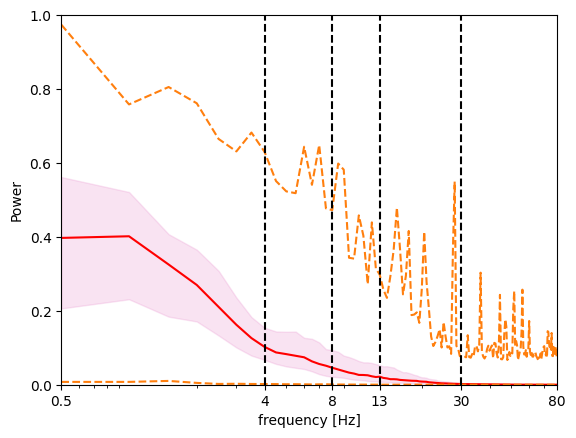

In [259]:
median, mean, std = plotPaperFigures(f_ab, psd_ab, show_fig=True)

In [256]:
f_n, psd_n = welchMethod(normal_signals ,200)

(84, 201)


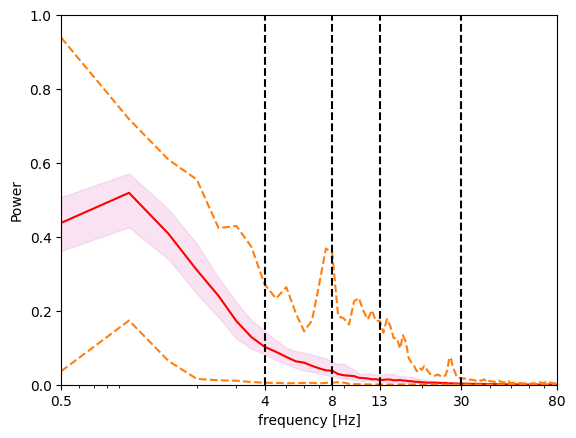

In [257]:
median, mean, std = plotPaperFigures(f_n, psd_n, show_fig=True)

(84, 201)


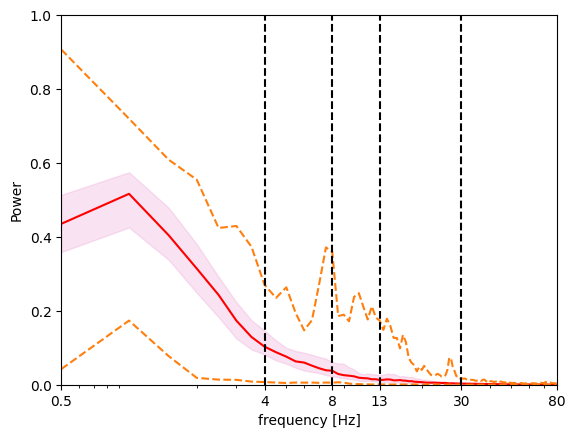

In [260]:
# This proves that I'm filtering well!
f_n2, psd_n2 = welchMethod(test_normal ,200)
_,_,_=plotPaperFigures(f_n2, psd_n2, show_fig=True)

### Extract features

In [261]:
signals_class = {
    'normal': normal_signals,
    'abnormal': abnormal_signals
}
psd_class = dict()
f_class = {}
for type_signal in signals_class:
    f_class[type_signal], psd_class[type_signal] = welchMethod(signals_class[type_signal] ,200)
    print(psd_class[type_signal].shape)

(84, 201)
(84, 159)
(556, 201)
(556, 159)


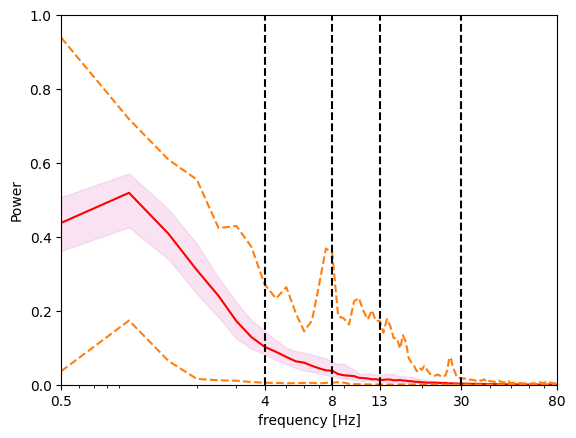

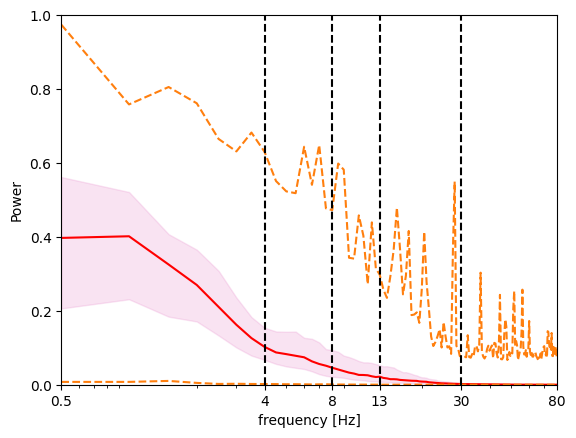

In [262]:
# Extract median, mean and std
median_class = {}
std_class = {}
mean_class = {}
for type_signal in psd_class:
    # Extract data
    # print(region)
    psd = psd_class[type_signal]
    f = f_class[type_signal]
    # # Plot and save the median curve
    median, mean, std = plotPaperFigures(f, psd, show_fig=True)
    median_class[type_signal] = median
    std_class[type_signal] = std
    mean_class[type_signal] = mean

In [263]:
# Extract errors per band
# extract the MAD
MAD_class = {}
for type_signal in psd_class:
    psd = psd_class[type_signal]
    MAD_class[type_signal] = np.median(np.abs(np.subtract(psd,median_class[type_signal])), axis=0)

In [264]:
def errorModifiedZScore(median, MAD, y_pred):
    # Center signal
    y_centered = np.subtract(y_pred, median)
    N = len(y_pred)
    return np.sum(np.divide(y_centered, MAD, out=np.zeros_like(y_centered), where=MAD!=0))/N

In [265]:
# Using the RMSE (ALWAYS against normal class)
errors_class = {
    'normal' : [],
    'abnormal' : []
}
for type_signal in psd_class:
    # Extract data per signal
    for idx, psd in enumerate(psd_class[type_signal]):
        # print(psd.shape)
        # Calculate error per freq band
        freq_bands = [0.5,4,8,13,30,80]
        rmse_bands = []
        for i in range(len(freq_bands)-1):
            idx0 = np.argmin(np.abs(f_class[type_signal]-freq_bands[i]))
            idx1 = np.argmin(np.abs(f_class[type_signal]-freq_bands[i+1]))
            # rmse_bands.append(error_std(mean_region[region][idx0:idx1], std_region[region][idx0:idx1], psd[idx0:idx1].squeeze()))
            rmse_bands.append(errorModifiedZScore(median_class['normal'][idx0:idx1], MAD_class['normal'][idx0:idx1], psd[idx0:idx1].squeeze()))
        tmp_dict = {
            'Error Delta': np.round(rmse_bands[0], decimals=4),
            'Error Theta': np.round(rmse_bands[1], decimals=4),
            'Error Alpha': np.round(rmse_bands[2], decimals=4),
            'Error Beta': np.round(rmse_bands[3], decimals=4),
            'Error Gamma': np.round(rmse_bands[4], decimals=4)
        }
        errors_class[type_signal].append(tmp_dict)

In [266]:
# Get bandpower per freq band
def bandpower(Pxx, f, fmin, fmax):
    ind_min = np.argmax(f > fmin) - 1
    ind_max = np.argmax(f > fmax) - 1
    return np.trapz(Pxx[ind_min: ind_max], f[ind_min: ind_max])

In [267]:
from sklearn.preprocessing import normalize
bandpower_class = {
    'normal' : [],
    'abnormal' : []
}
for type_signal in psd_class:
    # Extract data per signal
    for idx, psd in enumerate(psd_class[type_signal]):
        # print(psd.shape)
        # Calculate error per freq band
        freq_bands = [0.5,4,8,13,30,80]
        bandpow_bands = []
        for i, band in enumerate(tmp_dict): 
            bandpow = bandpower(psd.squeeze(), f_class[type_signal], freq_bands[i], freq_bands[i+1])
            bandpow_bands.append(np.round(bandpow, decimals=4))
        # Normalize (used l1 as it's based on Euclidean distance, same as here: https://github.com/jbernabei/iEEG_atlas/blob/main/support_files/create_univariate_atlas.m#L1)
        bandpow_bands = np.array([bandpow_bands])
        bandpow_bands = normalize(bandpow_bands, norm='l1')
        tmp_dict = {
            'Bandpower Delta': bandpow_bands.squeeze()[0],
            'Bandpower Theta': bandpow_bands.squeeze()[1],
            'Bandpower Alpha': bandpow_bands.squeeze()[2],
            'Bandpower Beta': bandpow_bands.squeeze()[3],
            'Bandpower Gamma': bandpow_bands.squeeze()[4]
        }
        bandpower_class[type_signal].append(tmp_dict)

In [274]:
# Calculate critical slowing features: std dev and autocorrelation
standard_dev_class = dict()
autocorr_class = dict()
for type_signal in signals_class:
    standard_dev_class[type_signal] =np.std(signals_class[type_signal], axis=1)
    autocorr_list = []
    for signal in signals_class[type_signal]:
        autocorr = np.correlate(signal, signal, mode='full')
        # Grabbing the mean value (not sure if the best)
        autocorr_list.append(np.mean(np.abs(autocorr[int(autocorr.size/2):])))
    autocorr_class[type_signal] = np.array(autocorr_list)

In [275]:
# Build dataframes and put them together
df_bandpower_normal = pd.DataFrame(bandpower_class['normal'])
df_errors_normal = pd.DataFrame(errors_class['normal'])
df_normal = pd.concat((df_bandpower_normal, df_errors_normal), axis=1)
df_normal['std_dev'] = standard_dev_class['normal']
df_normal['autocorr'] = autocorr_class['normal']
df_normal['type'] = 'normal'
df_normal.head()

,Bandpower Delta,Bandpower Theta,Bandpower Alpha,Bandpower Beta,Bandpower Gamma,Error Delta,Error Theta,Error Alpha,Error Beta,Error Gamma,std_dev,autocorr,type
0,0.549626,0.275517,0.092214,0.059224,0.023419,0.6535,3.5245,1.3141,-0.2018,-0.6177,18.771919,50291.134503,normal
1,0.480294,0.160820,0.192269,0.128011,0.038605,-0.2307,1.3264,6.2607,2.2098,0.5209,12.637420,23457.307659,normal
2,0.701216,0.187287,0.044795,0.044598,0.022103,0.4839,0.8330,-0.6419,-0.7800,-0.8469,47.877863,464602.941537,normal
3,0.731674,0.144025,0.046335,0.056018,0.021948,0.1338,-0.3116,-0.7522,-0.6274,-0.9533,45.481472,472369.380279,normal
4,0.712577,0.166096,0.055997,0.041123,0.024207,0.0410,0.1902,-0.5001,-1.0253,-0.6403,6.324183,8181.751247,normal


In [276]:
# Build dataframes and put them together
df_bandpower_abnormal = pd.DataFrame(bandpower_class['abnormal'])
df_errors_abnormal = pd.DataFrame(errors_class['abnormal'])
df_abnormal = pd.concat((df_bandpower_abnormal, df_errors_abnormal), axis=1)
df_abnormal['std_dev'] = standard_dev_class['abnormal']
df_abnormal['autocorr'] = autocorr_class['abnormal']
df_abnormal['type'] = 'abnormal'
df_abnormal.head()

,Bandpower Delta,Bandpower Theta,Bandpower Alpha,Bandpower Beta,Bandpower Gamma,Error Delta,Error Theta,Error Alpha,Error Beta,Error Gamma,std_dev,autocorr,type
0,0.435719,0.263496,0.097038,0.138281,0.065467,-0.1941,4.2402,2.1989,2.6924,3.7485,11.627719,18922.590020,abnormal
1,0.523410,0.260809,0.061403,0.099678,0.054700,0.3534,3.4871,0.4105,1.3856,2.3247,13.717952,28433.489120,abnormal
2,0.512074,0.294275,0.075795,0.086690,0.031167,0.4235,4.1627,0.9789,0.6391,0.4395,16.198732,37563.688719,abnormal
3,0.483660,0.346086,0.074393,0.067379,0.028482,0.2396,5.2923,0.8115,0.0101,0.0715,17.588944,44449.737629,abnormal
4,0.476633,0.219409,0.096627,0.129239,0.078092,0.8230,3.2037,2.4605,2.5476,4.1064,7.943406,8272.308173,abnormal


In [277]:
df_all = pd.concat((df_normal, df_abnormal), axis=0)
df_all.head()

,Bandpower Delta,Bandpower Theta,Bandpower Alpha,Bandpower Beta,Bandpower Gamma,Error Delta,Error Theta,Error Alpha,Error Beta,Error Gamma,std_dev,autocorr,type
0,0.549626,0.275517,0.092214,0.059224,0.023419,0.6535,3.5245,1.3141,-0.2018,-0.6177,18.771919,50291.134503,normal
1,0.480294,0.160820,0.192269,0.128011,0.038605,-0.2307,1.3264,6.2607,2.2098,0.5209,12.637420,23457.307659,normal
2,0.701216,0.187287,0.044795,0.044598,0.022103,0.4839,0.8330,-0.6419,-0.7800,-0.8469,47.877863,464602.941537,normal
3,0.731674,0.144025,0.046335,0.056018,0.021948,0.1338,-0.3116,-0.7522,-0.6274,-0.9533,45.481472,472369.380279,normal
4,0.712577,0.166096,0.055997,0.041123,0.024207,0.0410,0.1902,-0.5001,-1.0253,-0.6403,6.324183,8181.751247,normal


In [278]:
# Save
df_all.to_csv('all_features_v2.tsv', sep='\t')

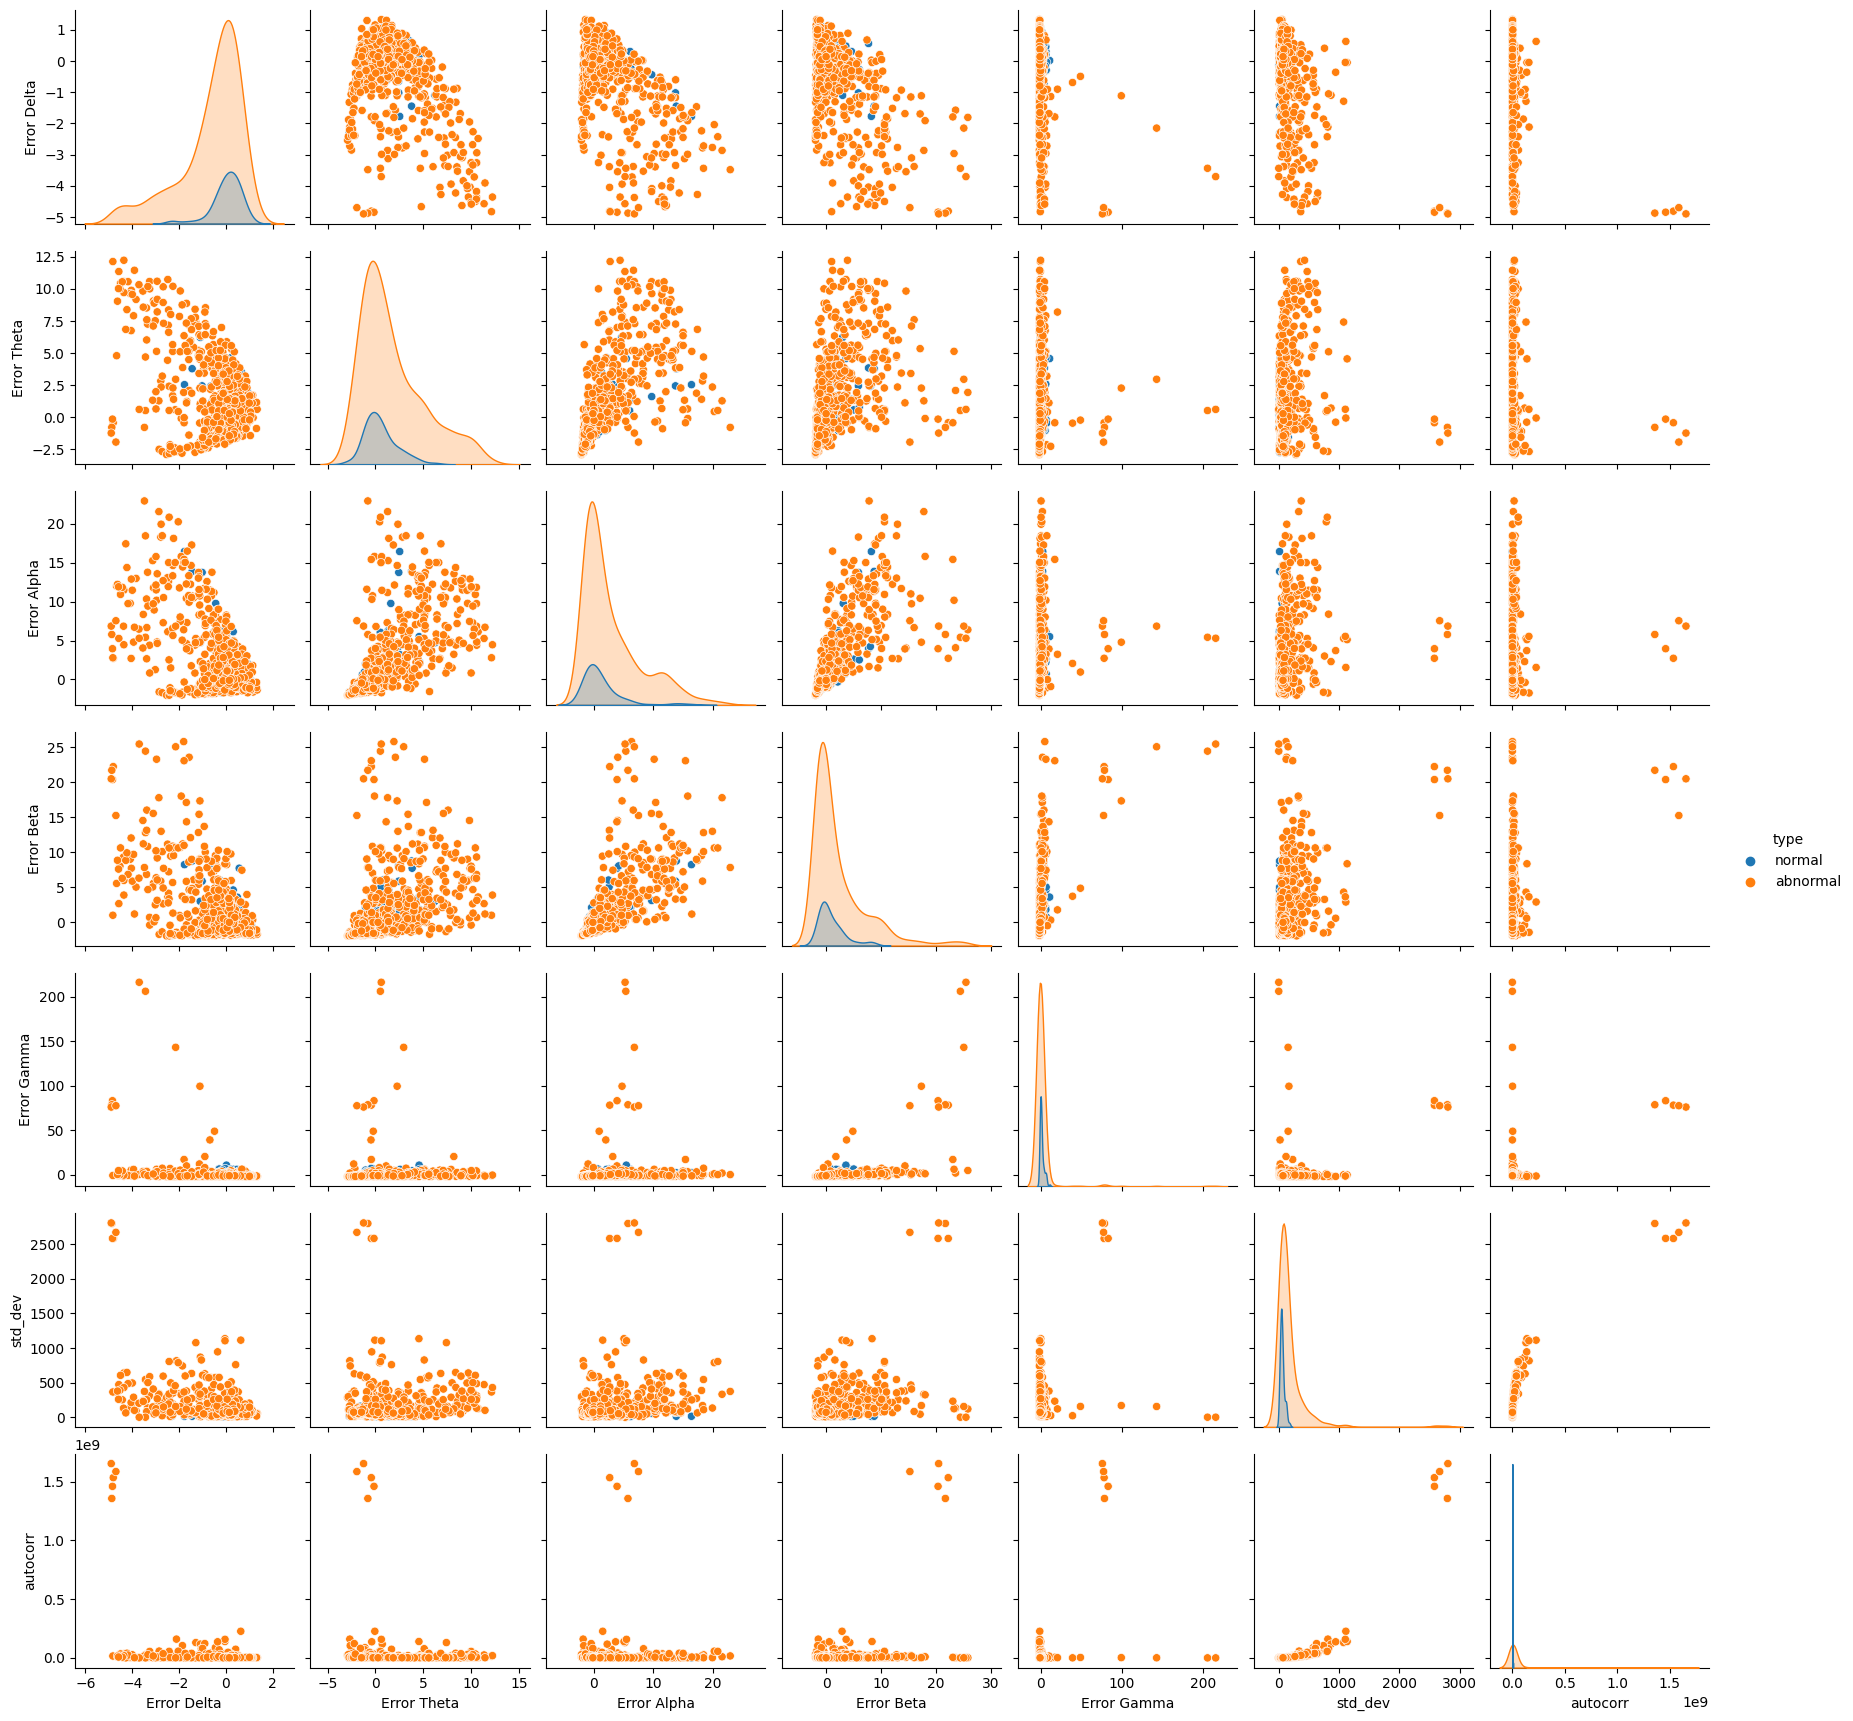

In [279]:
import seaborn as sns
sns.pairplot(df_all.drop(['Bandpower Delta', 'Bandpower Theta', 'Bandpower Alpha', 'Bandpower Beta', 'Bandpower Gamma'], axis=1), hue="type")

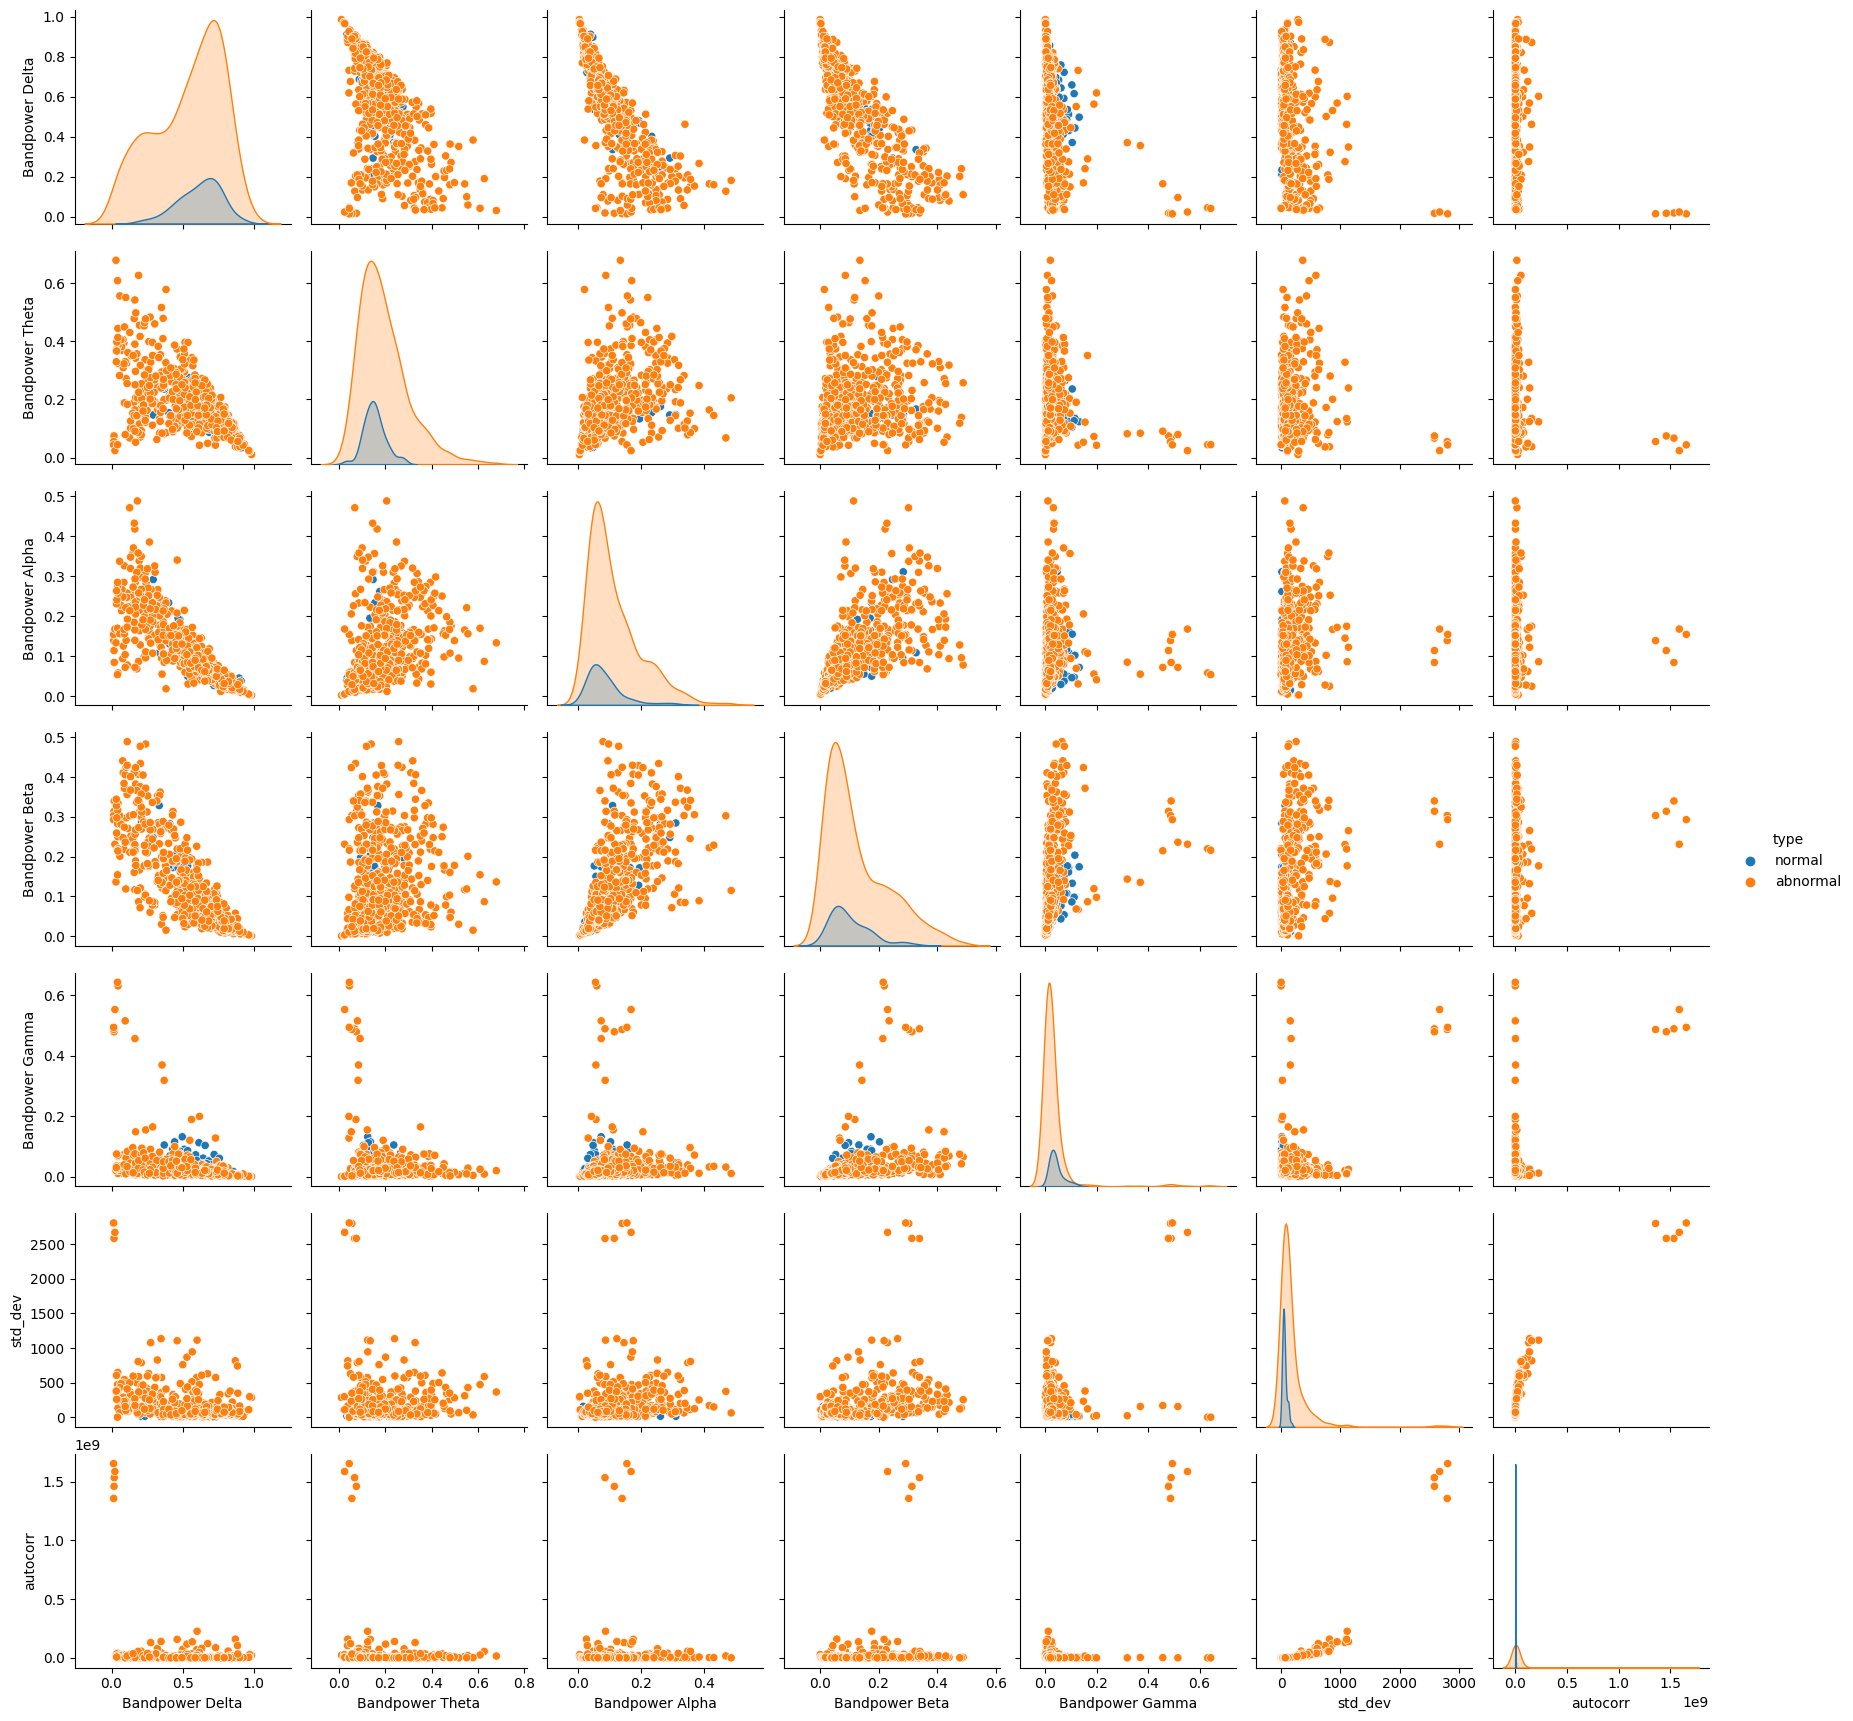

In [280]:
sns.pairplot(df_all.drop(['Error Delta', 'Error Theta', 'Error Alpha', 'Error Beta', 'Error Gamma'], axis=1), hue="type")

## Try PCA

In [282]:
from sklearn.decomposition import PCA
import plotly.express as px

### Case 1: Bandpower

In [283]:
features_df = df_all.loc[:, ['Bandpower Delta', 'Bandpower Theta', 'Bandpower Alpha', 'Bandpower Beta', 'Bandpower Gamma']].to_numpy()
features_df.shape

(640, 5)

In [284]:
# Normalize first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features_df)
features

array([[ 0.00649384,  0.87805522, -0.21272491, -0.620845  , -0.12827073],
       [-0.28997298, -0.25814011,  1.01238935,  0.04464806,  0.09794073],
       [ 0.65470915,  0.00404566, -0.79334982, -0.76234448, -0.14788063],
       ...,
       [ 0.37512933,  0.59694771, -0.54231843, -0.80139776, -0.310772  ],
       [ 0.17250495,  0.69433135, -0.23846602, -0.70057858, -0.27623684],
       [ 0.46336129, -0.16271147, -0.58157912, -0.31715897, -0.17363264]])

In [285]:
# Try PCA on PSD 
# Apply PCA on training data and get the explained variance [ / 4 marks]
PCA_alg = PCA() # 64 is the minimum between the training examples and the # of features
PCA_alg.fit(features)

# Print the variance:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)

# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.8)+1
print(f'The minimum number of components to get a variance above 80% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')

The total explained variance using 5 components is 100.000 percent.
The minimum number of components to get a variance above 80% is 2.000, with a value of 80.966%


In [286]:
# Create PCA with 3 features to visualize (preserves more than 80% of variance)
# Get results
PCA_vis = PCA(n_components = 3)
psd_vis = PCA_vis.fit_transform(features)
psd_vis.shape

(640, 3)

In [287]:
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = psd_vis, columns = features_plot)
df_plot['type'] = df_all['type'].values
df_plot.head()

,1 component,2 component,3 component,type
0,-0.173643,-0.733651,0.794704,normal
1,0.646636,0.108014,-0.490405,normal
2,-1.204708,-0.189164,0.413316,normal
3,-1.351659,0.085964,0.072939,normal
4,-1.241283,-0.066299,0.245972,normal


In [ ]:
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()
# Not as bad

### Case 2: Errors

In [289]:
features_df = df_all.loc[:, ['Error Delta', 'Error Theta', 'Error Alpha', 'Error Beta', 'Error Gamma']].to_numpy()
features_df.shape

(640, 5)

In [290]:
# Normalize first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features_df)
features.shape

(640, 5)

In [291]:
# Try PCA on PSD 
# Apply PCA on training data and get the explained variance [ / 4 marks]
PCA_alg = PCA() # 64 is the minimum between the training examples and the # of features
PCA_alg.fit(features)

# Print the variance:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)

# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.8)+1
print(f'The minimum number of components to get a variance above 80% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')
print(f'Variance with 3 components {cum_sum_var[3]*100:.3f}%')

The total explained variance using 5 components is 100.000 percent.
The minimum number of components to get a variance above 80% is 3.000, with a value of 88.174%
Variance with 3 components 96.483%


In [ ]:
# Create PCA with 3 features to visualize (preserves more than 80% of variance)
# Get results
PCA_vis = PCA(n_components = 3)
psd_vis = PCA_vis.fit_transform(features)
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = psd_vis, columns = features_plot)
df_plot['type'] = df_all['type'].values
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()
# Not amazing as well but I think better than la

### Case 3: Errors + std_dev + autocorr

In [293]:
features_df = df_all.loc[:, ['Error Delta', 'Error Theta', 'Error Alpha', 'Error Beta', 'Error Gamma', 'std_dev', 'autocorr']].to_numpy()
features_df.shape

(640, 7)

In [294]:
# Normalize first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features_df)
features.shape

(640, 7)

In [295]:
# Try PCA on PSD 
# Apply PCA on training data and get the explained variance [ / 4 marks]
PCA_alg = PCA() # 64 is the minimum between the training examples and the # of features
PCA_alg.fit(features)

# Print the variance:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)

# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.8)+1
print(f'The minimum number of components to get a variance above 80% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')
print(f'Variance with 3 components {cum_sum_var[3]*100:.3f}%')

The total explained variance using 7 components is 100.000 percent.
The minimum number of components to get a variance above 80% is 3.000, with a value of 83.748%
Variance with 3 components 90.576%


In [ ]:
# Create PCA with 3 features to visualize (preserves more than 80% of variance)
# Get results
PCA_vis = PCA(n_components = 3)
psd_vis = PCA_vis.fit_transform(features)
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = psd_vis, columns = features_plot)
df_plot['type'] = df_all['type'].values
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()
# Not amazing as well but I think better 

### Case 4: Bandpower + std_dev + autocorr

In [297]:
features_df = df_all.loc[:, ['Bandpower Delta', 'Bandpower Theta', 'Bandpower Alpha', 'Bandpower Beta', 'Bandpower Gamma', 'std_dev', 'autocorr']].to_numpy()
features_df.shape

(640, 7)

In [298]:
# Normalize first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features_df)
features.shape

(640, 7)

In [299]:
# Try PCA on PSD 
# Apply PCA on training data and get the explained variance [ / 4 marks]
PCA_alg = PCA() # 64 is the minimum between the training examples and the # of features
PCA_alg.fit(features)

# Print the variance:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)

# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.8)+1
print(f'The minimum number of components to get a variance above 80% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')
print(f'Variance with 3 components {cum_sum_var[3]*100:.3f}%')

The total explained variance using 7 components is 100.000 percent.
The minimum number of components to get a variance above 80% is 3.000, with a value of 86.509%
Variance with 3 components 94.702%


In [ ]:
# Create PCA with 3 features to visualize (preserves more than 80% of variance)
# Get results
PCA_vis = PCA(n_components = 3)
psd_vis = PCA_vis.fit_transform(features)
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = psd_vis, columns = features_plot)
df_plot['type'] = df_all['type'].values
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()
# Not amazing as well but I think better than la

### Case 5: all features

In [301]:
features_df = df_all.drop(['type'], axis=1).to_numpy()
features_df.shape

(640, 12)

In [302]:
# Normalize first
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = scaler.fit_transform(features_df)
features.shape

(640, 12)

In [303]:
# Try PCA on PSD 
# Apply PCA on training data and get the explained variance [ / 4 marks]
PCA_alg = PCA() # 64 is the minimum between the training examples and the # of features
PCA_alg.fit(features)

# Print the variance:
total_variance = np.sum(PCA_alg.explained_variance_ratio_)*100
print('The total explained variance using %i components is %.3f percent.' % (PCA_alg.n_components_, total_variance))

# Plotting explained variance with number of concepts [ / 4 marks]
exp_var_ratio = PCA_alg.explained_variance_ratio_
#
cum_sum_var = np.cumsum(exp_var_ratio)

# To get the exact index where the variance is above 80%
id = np.argmax(cum_sum_var > 0.8)+1
print(f'The minimum number of components to get a variance above 80% is {id:.3f}, with a value of {cum_sum_var[id-1]*100:.3f}%')
print(f'Variance with 3 components {cum_sum_var[3]*100:.3f}%')

The total explained variance using 12 components is 100.000 percent.
The minimum number of components to get a variance above 80% is 3.000, with a value of 81.919%
Variance with 3 components 90.408%


In [ ]:
# Create PCA with 3 features to visualize (preserves more than 80% of variance)
# Get results
PCA_vis = PCA(n_components = 3)
psd_vis = PCA_vis.fit_transform(features)
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = psd_vis, columns = features_plot)
df_plot['type'] = df_all['type'].values
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()
# Not amazing as well but I think better than la

In [ ]:
# t-sne
from sklearn.manifold import TSNE
tSNEmapper = TSNE(n_components=3,               # How many dimensions to use. Never more than 2 or 3
                  init='random',                # First initialization. Sparse matrices need 'random'.  Otherwise use 'pca'
                  perplexity=150.0,              # Read below
                  early_exaggeration=12.0,      # Read below
                  learning_rate='auto',         # Related to above. Leave to auto
                  n_iter=5000,                  # Very important to let iterate enough
                  n_iter_without_progress=300,  # Set early stopping
                  metric='cosine',           # Metric to use to calculate distances.
                  min_grad_norm=1e-7,           # Minimum gradient to continue iterating
                  verbose=0,                    # Verbosity
                  random_state=42,              # Random seed
                  n_jobs=4,                     # Parallel processes
                 )
TSNE_embedding = tSNEmapper.fit_transform(features)
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = TSNE_embedding, columns = features_plot)
df_plot['type'] = df_all['type'].values
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()

In [ ]:
# UMAP
import umap
import umap.plot
# UMAP
# Let's create the object
reducer = umap.UMAP(n_neighbors=15,              # Number of neareast neighbours to use. 
                    n_components=3,              # Number of components. UMAP is robust to larger values
                    # metric='hellinger',          # Metric to use.
                    n_epochs=None,               # Iterations. Set to convergence. None implies either 200 or 500.
                    min_dist=0.1,                # Minimum distance embedded points. Smaller makes clumps, larger, sparseness.
                    spread=1.0,                  # Scale to combine with min_dist
                    low_memory=True,             # Run slower, but with less memory.
                    n_jobs=-1,                   # Cores to use
                    random_state=42,             # Random seed
                    verbose=True                 # Verbosity
                   )

# Now we train and calculate the embedding!
UMAP_embedding = reducer.fit_transform(features)
features_plot = [f'{k+1} component' for k in range(3)]
df_plot = pd.DataFrame(data = UMAP_embedding, columns = features_plot)
df_plot['type'] = df_all['type'].values
fig = px.scatter_3d(df_plot, x='1 component', y='2 component', z='3 component', color = 'type')
fig.show()

## Tune parameters

Text(0, 0.5, 'Power')

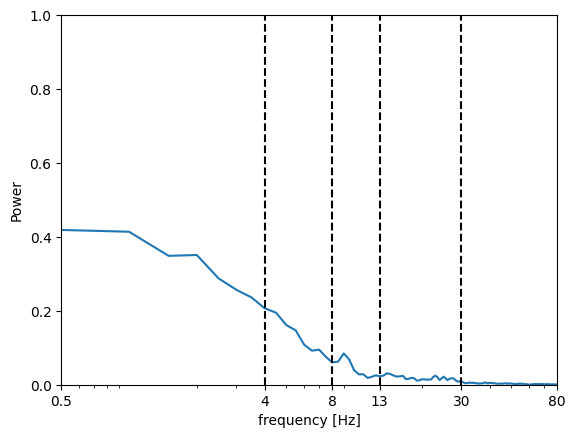

In [145]:
fig, ax = plt.subplots()
x_val = [0.5, 4, 8, 13, 30, 80]
default_x_ticks = range(len(x_val))
ax.semilogx(f_n, psd_n[20,:])
ax.semilogx([4, 4], [0, 1.1], '--k')
ax.semilogx([8, 8], [0, 1.1], '--k')
ax.semilogx([13, 13], [0, 1.1], '--k')
ax.semilogx([30, 30], [0, 1.1], '--k')
ax.set_xticks(x_val)
ax.set_xticklabels(x_val)
ax.set_xlim([0.5,80])
ax.set_ylim([0, 1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Power')

In [67]:
# Get HUP patients with normal electrodes
patients_hipp = patient_no[mask_hipp[0:len(patient_no)]]
print(len(patients_hipp))
patients_hipp = patients_hipp[(~abnormal_mask_hipp[0:len(patients_hipp)])]
print(len(np.unique(patients_hipp)))
print(len(patients_hipp))
patients_hipp[10]

276
8
11


55

In [68]:
# chn_position_HUP
chn_hipp = chn_position_HUP[mask_hipp[0:len(chn_position_HUP)]]
print(len(chn_hipp))
chn_hipp = chn_hipp[(~abnormal_mask_hipp[0:len(chn_hipp)])]
print(len(chn_hipp))
chn_hipp[10,:] # electrode LB02 -> LB01

276
11


array([-36.04305   , -19.3187    , -14.06448021])

In [69]:
(-37.8662+-34.2199)/2

-36.04305

In [210]:
edf_test = pyedflib.EdfReader('/home/mcesped/projects/ctb-akhanf/mcesped/Bernabei/sub-HUP180/ses-presurgery/ieeg/sub-HUP180_ses-presurgery_task-interictal_acq-seeg_run-01_ieeg.edf')

In [211]:
idx_1 = edf_test.getSignalLabels().index('LB01')

In [212]:
srate_orig = edf_test.getSampleFrequency(idx_1)
srate_orig

512.0

In [213]:
edf_test.readSignal(idx_1).shape

(153600,)

(513,)


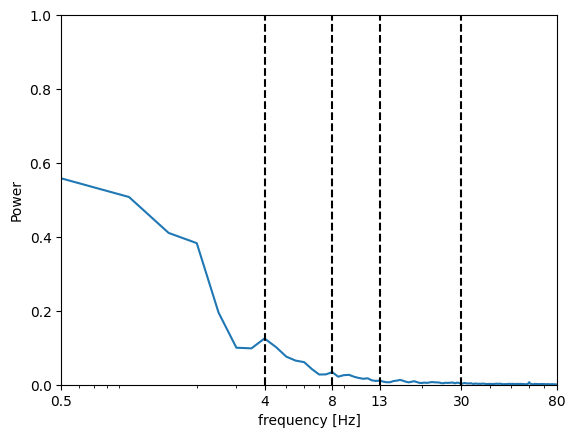

(513,)


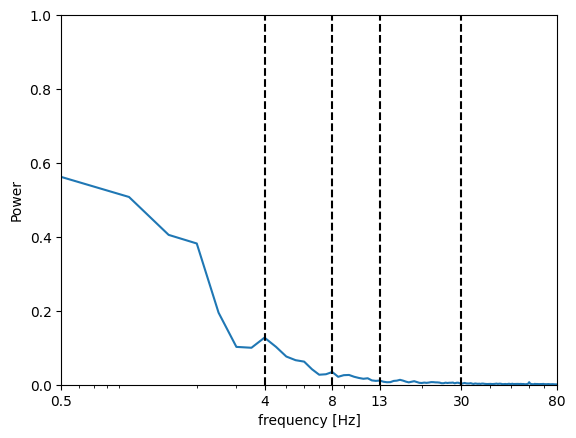

(513,)


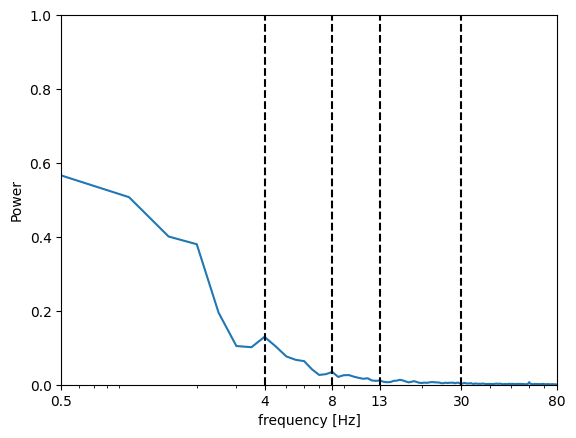

(513,)


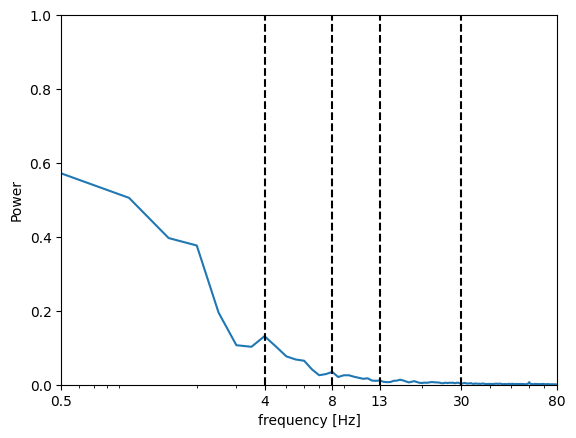

(513,)


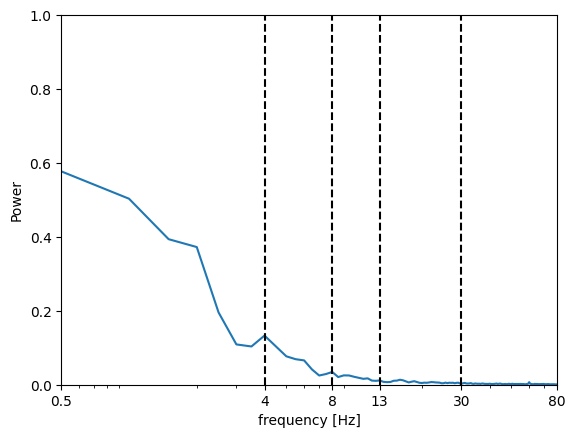

(513,)


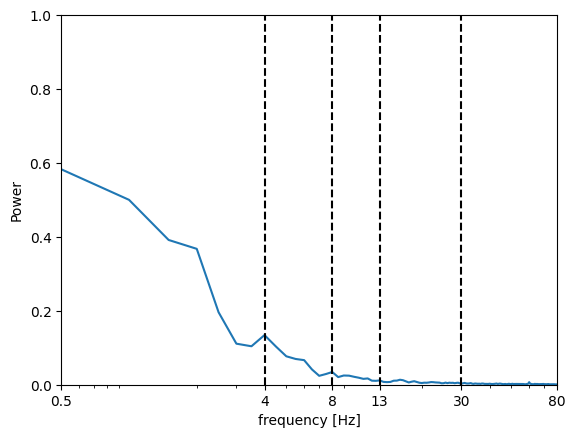

(513,)


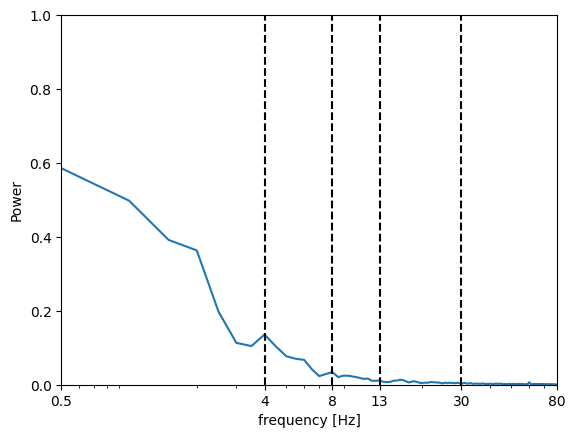

(513,)


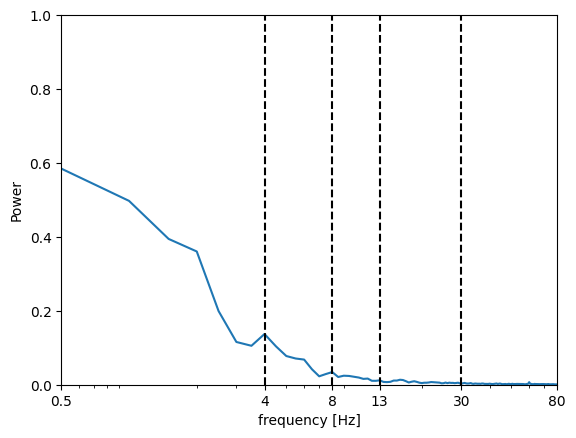

(513,)


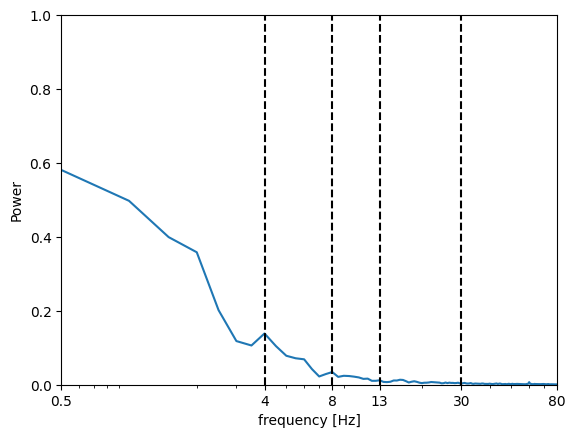

(513,)


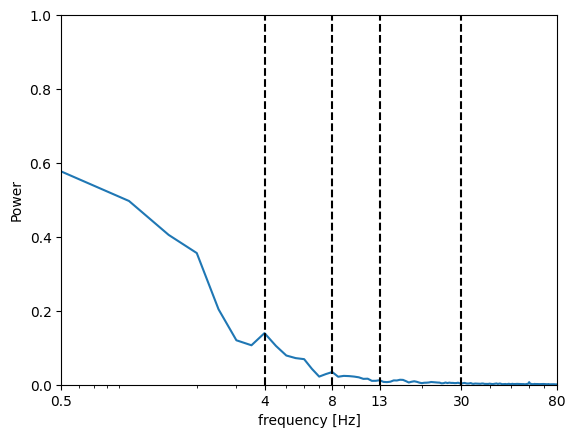

In [218]:
for i in range(0,int(153600/15360)): #int(153600/15360)
    sig1 = edf_test.readSignal(idx_1, 15*i, 512*30)
    sig2 = edf_test.readSignal(idx_1+1, 15*i, 512*30)
    bip = sig1-sig2
    f, psd = welchMethod(bip, srate_orig)
    fig, ax = plt.subplots()
    x_val = [0.5, 4, 8, 13, 30, 80]
    default_x_ticks = range(len(x_val))
    ax.semilogx(f, psd)
    ax.semilogx([4, 4], [0, 1.1], '--k')
    ax.semilogx([8, 8], [0, 1.1], '--k')
    ax.semilogx([13, 13], [0, 1.1], '--k')
    ax.semilogx([30, 30], [0, 1.1], '--k')
    ax.set_xticks(x_val)
    ax.set_xticklabels(x_val)
    ax.set_xlim([0.5,80])
    ax.set_ylim([0, 1])
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('Power')
    plt.show()

(513,)


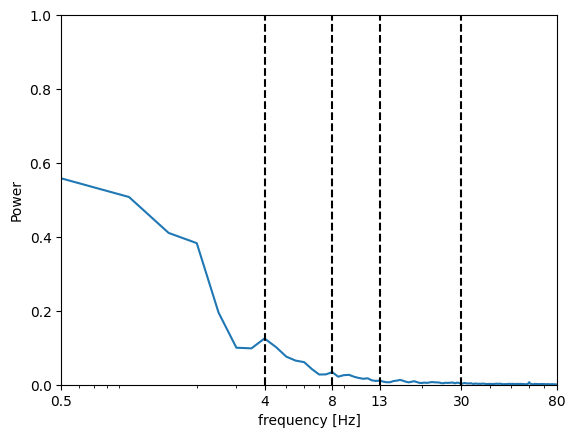

In [223]:
sig1 = edf_test.readSignal(idx_1, 0, 512*30)
sig2 = edf_test.readSignal(idx_1+1, 0, 512*30)
bip = sig2-sig1
f, psd = welchMethod(bip, 512)
fig, ax = plt.subplots()
x_val = [0.5, 4, 8, 13, 30, 80]
default_x_ticks = range(len(x_val))
ax.semilogx(f, psd)
ax.semilogx([4, 4], [0, 1.1], '--k')
ax.semilogx([8, 8], [0, 1.1], '--k')
ax.semilogx([13, 13], [0, 1.1], '--k')
ax.semilogx([30, 30], [0, 1.1], '--k')
ax.set_xticks(x_val)
ax.set_xticklabels(x_val)
ax.set_xlim([0.5,80])
ax.set_ylim([0, 1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Power')
plt.show()

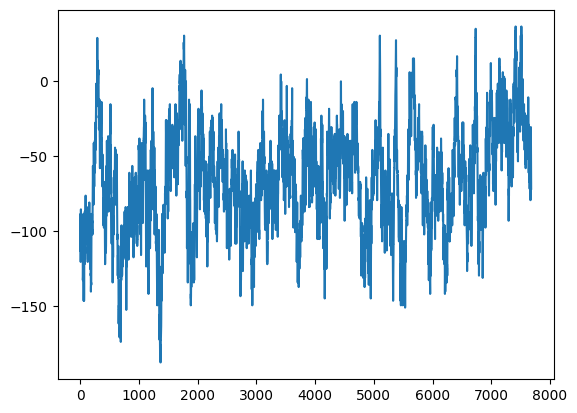

In [216]:
plt.plot(bip)

In [224]:
signal_prec =  preprocessed_signal(bip, 512, 200, Transition=[0.1, 0.23], Attenuation=30)

(6000,)
1183
(6000,)


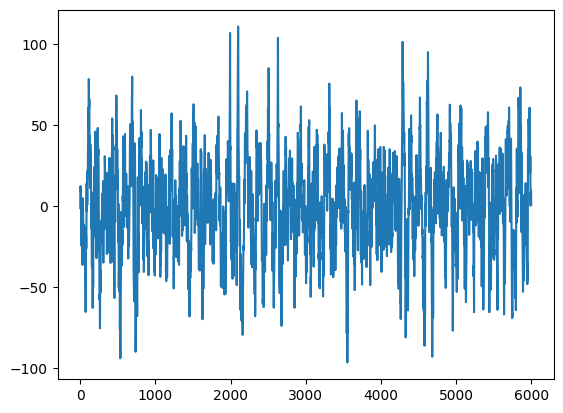

In [163]:
plt.plot(signal_prec)

(201,)


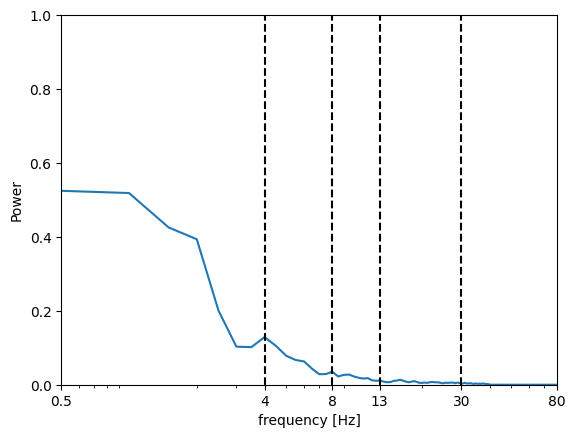

In [225]:
f, psd = welchMethod(signal_prec,200)
fig, ax = plt.subplots()
x_val = [0.5, 4, 8, 13, 30, 80]
default_x_ticks = range(len(x_val))
ax.semilogx(f, psd)
ax.semilogx([4, 4], [0, 1.1], '--k')
ax.semilogx([8, 8], [0, 1.1], '--k')
ax.semilogx([13, 13], [0, 1.1], '--k')
ax.semilogx([30, 30], [0, 1.1], '--k')
ax.set_xticks(x_val)
ax.set_xticklabels(x_val)
ax.set_xlim([0.5,80])
ax.set_ylim([0, 1])
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('Power')
plt.show()

In [209]:
edf_test.close()